In [2]:
!pip install ultralytics

In [3]:
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import re
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import contextlib
import io
from PIL import Image
import torchvision.transforms as transforms
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [3]:
# Thiết lập device cho PyTorch (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Các tham số
SIZE = 128  # Kích thước ảnh đầu vào
NoofIMGs = 9001
batch_size = 32

# Đường dẫn đến các thư mục ảnh
path_1 = 'C:/Sam C-Gan project/data/without_mask/train'
path_2 = 'C:/Sam C-Gan project/data/with_mask/train'

path_3='C:/Sam C-Gan project/data/without_mask/val'
path_4='C:/Sam C-Gan project/data/with_mask/val'
# Hàm sắp xếp alphanumeric
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Đọc danh sách file và lấy đường dẫn ảnh
# for train
files_1 = sorted_alphanumeric([f for f in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, f))])[:NoofIMGs]
files_2 = sorted_alphanumeric([f for f in os.listdir(path_2) if os.path.isfile(os.path.join(path_2, f))])[:NoofIMGs]
without_mask_paths = [os.path.join(path_1, fname).replace("\\", "/") for fname in files_1]
with_mask_paths = [os.path.join(path_2, fname).replace("\\", "/") for fname in files_2]

# for test
files_3 = sorted_alphanumeric([f for f in os.listdir(path_3) if os.path.isfile(os.path.join(path_3, f))])[:999]
files_4 = sorted_alphanumeric([f for f in os.listdir(path_4) if os.path.isfile(os.path.join(path_4, f))])[:999]
without_mask_val_paths = [os.path.join(path_3, fname).replace("\\", "/") for fname in files_3]
with_mask_val_paths = [os.path.join(path_4, fname).replace("\\", "/") for fname in files_4]

# Lớp Dataset tùy chỉnh
class MaskDataset(Dataset):
    def __init__(self, without_mask_paths, with_mask_paths, transform=None):
        self.without_mask_paths = without_mask_paths
        self.with_mask_paths = with_mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.without_mask_paths)

    def __getitem__(self, idx):
        # Đọc ảnh không có khẩu trang và có khẩu trang
        without_mask_img = Image.open(self.without_mask_paths[idx]).convert('RGB')
        with_mask_img = Image.open(self.with_mask_paths[idx]).convert('RGB')

        # Áp dụng biến đổi nếu có
        if self.transform:
            without_mask_img = self.transform(without_mask_img)
            with_mask_img = self.transform(with_mask_img)

        return without_mask_img, with_mask_img

# Các phép biến đổi (resize và chuẩn hóa)
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),   # Resize ảnh về kích thước 64x64
    transforms.ToTensor(),             # Chuyển ảnh thành tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa về [-1, 1]
])

# Tạo dataset và dataloader
dataset = MaskDataset(without_mask_paths, with_mask_paths, transform=transform)
valset=MaskDataset(without_mask_val_paths, with_mask_val_paths, transform=transform)

# Tạo DataLoader với shuffle và chia batch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)
valloader=DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0,drop_last=True)


In [5]:
# Hàm chuyển đổi ảnh tensor sang dạng có bounding box
def convert(image_tensor, model):
    # Chuyển từ [-1, 1] về [0, 255] và chuyển từ tensor PyTorch sang NumPy
    img_original = ((image_tensor.cpu().numpy().transpose(1, 2, 0) + 1) * 127.5).astype(np.uint8)
    
    # Kiểm tra số kênh của ảnh (phải là 3 kênh cho RGB)
    if img_original.shape[2] != 3:
        raise ValueError(f"Invalid image format: Expected 3 channels, but got {img_original.shape}")

    # Chuyển đổi từ RGB sang BGR và thay đổi kích thước ảnh
    img_rgb_original = cv2.cvtColor(img_original, cv2.COLOR_RGB2BGR)
    img_resized = cv2.resize(img_rgb_original, (640, 640))  # Resize về kích thước 640x640 cho YOLO

    # Chặn đầu ra từ YOLO bằng cách sử dụng contextlib
    with contextlib.redirect_stdout(io.StringIO()):
        results = model(img_resized, verbose=False)  # Thực hiện dự đoán với mô hình

    # Kiểm tra nếu results là list và xử lý bounding boxes từ YOLO
    if isinstance(results, list) and len(results) > 0:
        boxes = results[0].boxes  # Truy cập vào bounding boxes từ kết quả đầu tiên

        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())

            x1 = int(x1 * (128 / 640))
            y1 = int(y1 * (128 / 640))
            x2 = int(x2 * (128/ 640))
            y2 = int(y2 * (128/ 640))

            # Vẽ bounding box lên ảnh (màu đen)
            img_rgb_original = cv2.rectangle(img_rgb_original, (x1, y1), (x2, y2), color=(0, 0, 0), thickness=-1)
    else:
        raise ValueError("The result does not contain valid bounding boxes.")

    # Chuyển lại ảnh về định dạng RGB
    img_rgb_display = cv2.cvtColor(img_rgb_original, cv2.COLOR_BGR2RGB)
    return img_rgb_display

# Hàm áp dụng mask bounding box cho một batch ảnh
def apply_bounding_box_mask(image_batch, model):
    processed_images = []
    for image_tensor in image_batch:
        masked_image = convert(image_tensor, model)
        processed_images.append(masked_image)

    # Chuyển danh sách ảnh về tensor PyTorch
    processed_images = np.array(processed_images)
    processed_images = torch.from_numpy(processed_images).float()

    # Chuẩn hóa lại các ảnh về phạm vi [-1, 1]
    processed_images = (processed_images / 127.5) - 1
    return processed_images


In [9]:
# DISCRIMINATOR MODULE

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, block=ResidualBlock, all_connections=[2, 2, 2, 2]):
        super(Discriminator, self).__init__()
        self.inputs = 64  # Starting channels after the first convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )  # Output: 64x128x128
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x64x64

        # Residual layers
        self.layer0 = self.make_layer(block, 128, all_connections[0], stride=2)  # Output: 128x32x32
        self.layer1 = self.make_layer(block, 256, all_connections[1], stride=2)  # Output: 256x16x16
        self.layer2 = self.make_layer(block, 512, all_connections[2], stride=2)  # Output: 512x8x8
        self.layer3 = self.make_layer(block, 1024, all_connections[3], stride=2)  # Output: 1024x4x4

        # Average Pooling
        self.globalpool = nn.AvgPool2d(kernel_size=4)  # Output: 1024x1x1

        # Fully connected layers
        self.fc = nn.Linear(1024, 1)

    def make_layer(self, block, out_channels, connections, stride=1):
        downsample = None
        if stride != 1 or self.inputs != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.inputs, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.inputs, out_channels, stride, downsample))
        self.inputs = out_channels
        for _ in range(1, connections):
            layers.append(block(self.inputs, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x).flatten()
        return torch.sigmoid(x)


In [10]:
# Di chuyển mô hình lên GPU nếu có
discriminator = Discriminator().to(device)
# discriminator._initialize_weights()

# Tạo một tensor đầu vào giả (ví dụ ảnh RGB kích thước 256x256)
input_tensor = torch.randn(1, 3, 128, 128).to(device)  # Di chuyển input_tensor lên cùng thiết bị với mô hình

# Kiểm tra lại summary
summary(discriminator, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]           8,192
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
    ResidualBlock-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

In [ ]:
# GENERATOR MODULE

# Double Convolutional Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.conv_1 = DoubleConv(3, 64)  # 64x128x128
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64x64

        self.conv_2 = DoubleConv(64, 128)  # 128x64x64
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128x32x32

        self.conv_3 = DoubleConv(128, 256)  # 256x32x32
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256x16x16

        self.conv_4 = DoubleConv(256, 512)  # 512x16x16
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 512x8x8

        self.conv_5 = DoubleConv(512, 1024)  # 1024x8x8

        # Decoder
        self.upconv_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 512x16x16
        self.conv_6 = DoubleConv(1024, 512)  # 512x16x16

        self.upconv_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 256x32x32
        self.conv_7 = DoubleConv(512, 256)  # 256x32x32

        self.upconv_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 128x64x64
        self.conv_8 = DoubleConv(256, 128)  # 128x64x64

        self.upconv_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 64x128x128
        self.conv_9 = DoubleConv(128, 64)  # 64x128x128

        self.output = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)  # 3x128x128

    def forward(self, batch):
        # Encoder
        conv_1_out = self.conv_1(batch)
        conv_2_out = self.conv_2(self.pool_1(conv_1_out))
        conv_3_out = self.conv_3(self.pool_2(conv_2_out))
        conv_4_out = self.conv_4(self.pool_3(conv_3_out))
        conv_5_out = self.conv_5(self.pool_4(conv_4_out))

        # Decoder
        conv_6_out = self.conv_6(torch.cat([self.upconv_1(conv_5_out), conv_4_out], dim=1))
        conv_7_out = self.conv_7(torch.cat([self.upconv_2(conv_6_out), conv_3_out], dim=1))
        conv_8_out = self.conv_8(torch.cat([self.upconv_3(conv_7_out), conv_2_out], dim=1))
        conv_9_out = self.conv_9(torch.cat([self.upconv_4(conv_8_out), conv_1_out], dim=1))

        # Output Layer
        output = self.output(conv_9_out)

        return torch.tanh(output)


In [7]:
# Di chuyển mô hình lên GPU nếu có
generator = Generator().to(device)
# generator._initialize_weights()

# Tạo một tensor đầu vào giả (ví dụ ảnh RGB kích thước 256x256)
input_tensor = torch.randn(1, 3, 128, 128).to(device)  # Di chuyển input_tensor lên cùng thiết bị với mô hình

# Kiểm tra lại summary
summary(generator, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

In [13]:
learning_rate_gen = 0.0002 # Learning rate cho generator
learning_rate_disc = 0.00004 # Learning rate cho discriminator

generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_gen, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_disc, betas=(0.5, 0.999))


In [14]:
# Định nghĩa cross entropy loss
cross_entropy = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
# Hàm generator loss
def generator_loss(fake_output):
    # Mục tiêu của generator là đánh lừa discriminator, nên loss so sánh với '1'
    return cross_entropy( torch.ones_like(fake_output),fake_output)

# Hàm discriminator loss
def discriminator_loss(fake_output, real_output):
    # Mục tiêu của discriminator là phân biệt ảnh giả và ảnh thật
    fake_loss = cross_entropy(fake_output, torch.zeros(batch_size,device=device))  # So sánh fake với '0'
    real_loss = cross_entropy(real_output, torch.ones(batch_size,device=device))  # So sánh real với '1'
    return (real_loss + fake_loss)/2


real_output tensor(0.3297, device='cuda:0', grad_fn=<SelectBackward0>)
fake_output tensor(0.3157, device='cuda:0', grad_fn=<SelectBackward0>)


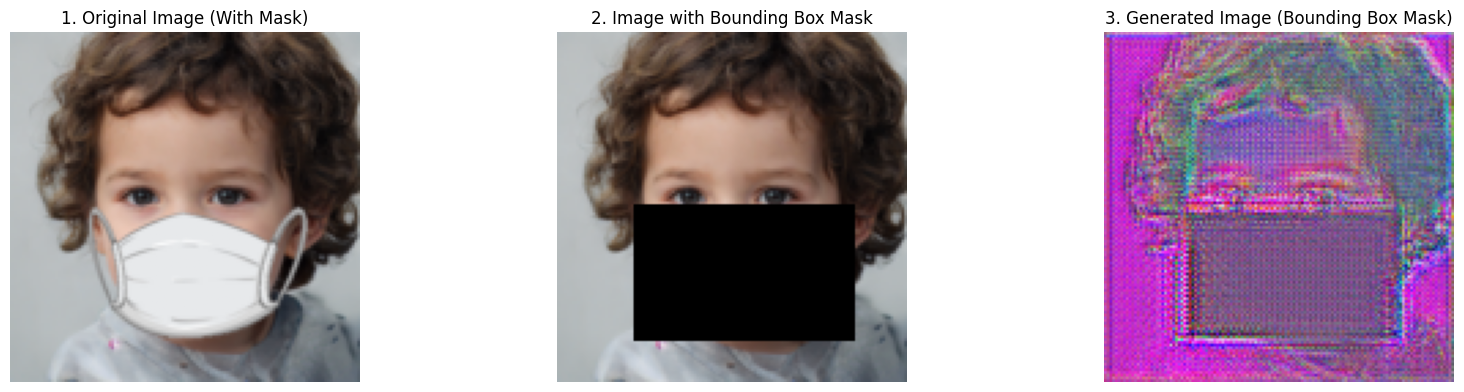

In [15]:

# Hàm hiển thị bốn ảnh theo yêu cầu
def display_images(generator, discriminator, model_yolo, dataloader):
    # Lấy một batch từ dataloader
    without_mask_batch, with_mask_batch = next(iter(dataloader))
    with_mask_batch = with_mask_batch.to(device)  # Đảm bảo ảnh được chuyển sang GPU nếu có

    # 1. Hiển thị ảnh gốc từ dataloader (ảnh có khẩu trang)
    img_original = with_mask_batch[0].cpu()  # Chọn ảnh đầu tiên trong batch và chuyển về CPU
    img_original = img_original * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
    img_original = img_original.permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) -> (H, W, C)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(img_original)
    plt.title("1. Original Image (With Mask)")
    plt.axis('off')

    # 2. Áp dụng bounding box mask lên ảnh có khẩu trang
    images_with_mask = apply_bounding_box_mask(with_mask_batch, model_yolo)
    img_with_mask = images_with_mask[0].cpu()  # Chọn ảnh đầu tiên trong batch và chuyển về CPU
    img_with_mask = img_with_mask * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa về [0, 1]
    img_with_mask = img_with_mask.numpy()  # Chuyển từ (C, H, W) -> (H, W, C)

    plt.subplot(2, 3, 2)
    plt.imshow(img_with_mask)
    plt.title("2. Image with Bounding Box Mask")
    plt.axis('off')

    # 3. Truyền ảnh có bounding box mask qua generator
    images_with_mask = images_with_mask.to(device)
    generated_images = generator(images_with_mask.permute(0, 3, 1, 2))  # Hoán đổi thứ tự chiều
    generated_image = generated_images[0].cpu().detach()  # Chọn ảnh đầu tiên và chuyển về CPU
    generated_image = generated_image * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
    generated_image = generated_image.permute(1, 2, 0).numpy()

    plt.subplot(2, 3, 3)
    plt.imshow(generated_image)
    plt.title("3. Generated Image (Bounding Box Mask)")
    plt.axis('off')

    # 4. Đầu ra từ discriminator
    real_output = discriminator(with_mask_batch)  # Đầu ra cho ảnh gốc
    fake_output = discriminator(generated_images)  # Đầu ra cho ảnh qua generator

    print('real_output',real_output[0])
    print('fake_output',fake_output[0])

# Gọi hàm display_images
model_yolo = YOLO("C:\\Sam C-Gan project\\bounding black box\\mask_detection.pt")
display_images(generator, discriminator, model_yolo, dataloader)


In [16]:
best_gen_loss = float('inf')
def train(epoch, dataloader, generator, discriminator, generator_optimizer, discriminator_optimizer, model_yolo):
    generator_save_path = "/kaggle/working/generator_best.pth"
    
    
    start = time.time()
    print(f"Epoch {epoch + 1}")

    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batch=0

    generator.train()
    discriminator.train()

    for without_mask_batch, with_mask_batch in tqdm(dataloader):
        # Đưa batch vào GPU nếu có
        without_mask_batch = without_mask_batch.to(device)
        with_mask_batch = with_mask_batch.to(device)

        # Train Discriminator
        discriminator_optimizer.zero_grad()
        
        images_with_mask = apply_bounding_box_mask(with_mask_batch, model_yolo).to(device)
        generated_images = generator(images_with_mask.permute(0, 3, 1, 2))
        fake_output = discriminator(generated_images.detach())
        real_output=discriminator(without_mask_batch)
        
        loss_D=discriminator_loss(fake_output,real_output)
        
        loss_D.backward()
        discriminator_optimizer.step()
        
        epoch_disc_loss+=loss_D.item()
            
        # Train Generator
        generator_optimizer.zero_grad()
  
        generated_images = generator(images_with_mask.permute(0, 3, 1, 2))
        fake_output = discriminator(generated_images.detach())
        
        loss_G_bce=generator_loss(fake_output)
        loss_G_l1=l1_loss(generated_images,without_mask_batch)
        loss_G=loss_G_bce+loss_G_l1
        
        loss_G.backward()
        generator_optimizer.step()

        epoch_gen_loss+=loss_G.item()

        num_batch+=1
    avg_gen_loss=epoch_gen_loss/num_batch
    avg_dis_loss=epoch_disc_loss/num_batch
     
    # In thông tin epoch
    print(f"Time: {np.round(time.time() - start, 3)} secs")
    print(f"Generator Train Loss: {avg_gen_loss} | Discriminator Train Loss: {avg_dis_loss}")



In [17]:
def validate(epoch, valloader, generator, discriminator, generator_optimizer, discriminator_optimizer, model_yolo,generator_save_path):
    global best_gen_loss   # Để lưu generator tốt nhất
    start = time.time()
    print(f"Epoch {epoch + 1}")

    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batch=0

    generator.eval()
    discriminator.eval()
    with torch.no_grad() :
        for without_mask_batch, with_mask_batch in tqdm(valloader):
            # Đưa batch vào GPU nếu có
            without_mask_batch = without_mask_batch.to(device)
            with_mask_batch = with_mask_batch.to(device)

            images_with_mask = apply_bounding_box_mask(with_mask_batch, model_yolo).to(device)
            generated_images = generator(images_with_mask.permute(0, 3, 1, 2))
            fake_output = discriminator(generated_images.detach())
            real_output=discriminator(without_mask_batch)
            
            loss_D=discriminator_loss(fake_output,real_output)
            
            epoch_disc_loss+=loss_D.item()
            
      
            fake_output = discriminator(generated_images.detach())
            
            loss_G_bce=generator_loss(fake_output)
            loss_G_l1=l1_loss(generated_images,without_mask_batch)
            loss_G=loss_G_bce+loss_G_l1

            epoch_gen_loss+=loss_G.item()

            num_batch+=1
        avg_gen_loss=epoch_gen_loss/num_batch
        avg_dis_loss=epoch_disc_loss/num_batch
     
        # In thông tin epoch
        print(f"Time: {np.round(time.time() - start, 3)} secs")
        print(f"Generator Val Loss: {avg_gen_loss} | Discriminator Val Loss: {avg_dis_loss}")
        # Lưu Generator tốt nhất dựa trên gen_loss của validation
        if avg_gen_loss < best_gen_loss:
            best_gen_loss = avg_gen_loss
            torch.save(generator.state_dict(), generator_save_path)
            print(f"Generator saved as best model with Val Generator Loss: {best_gen_loss}")
        
        generator_epoch_path = f"/kaggle/working/generator_epoch_{epoch + 1}.pth"
        torch.save(generator.state_dict(), generator_epoch_path)
        print(f"Generator saved for epoch {epoch + 1} at {generator_epoch_path}")

In [ ]:
def train_and_val(epochs,dataloader, valloader, generator, discriminator, generator_optimizer, discriminator_optimizer, model_yolo):
    for epoch in range(epochs):
        train(epoch, dataloader, generator, discriminator, generator_optimizer, discriminator_optimizer, model_yolo)
        validate(epoch, valloader, generator, discriminator, generator_optimizer, discriminator_optimizer, model_yolo)
        if epoch >=50:
            generator_epoch_path = f"/kaggle/working/generator_epoch_{epoch + 1}.pth"
            
            torch.save(generator.state_dict(), generator_epoch_path)
            print(f"Generator saved for epoch {epoch + 1} at {generator_epoch_path}")

In [20]:
model_yolo = YOLO('C:\\Sam C-Gan project\\bounding black box\\mask_detection.pt').to(device)

# Đường dẫn để lưu lại generator tốt nhất
generator_save_path = "C:\\Sam C-Gan project\\checkpoints\\generator_best.pth"

# Gọi hàm train
train_and_val(
    epochs=100,
    dataloader=dataloader,
    valloader=valloader,
    generator=generator,
    discriminator=discriminator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    model_yolo=model_yolo
)


Epoch 1


  0%|          | 0/281 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
generator_checkpoint = "C:\\Sam C-Gan project\\checkpoints\\generator_epoch_60.pth"

torch.save(generator.state_dict(), generator_checkpoint)


: 

: 

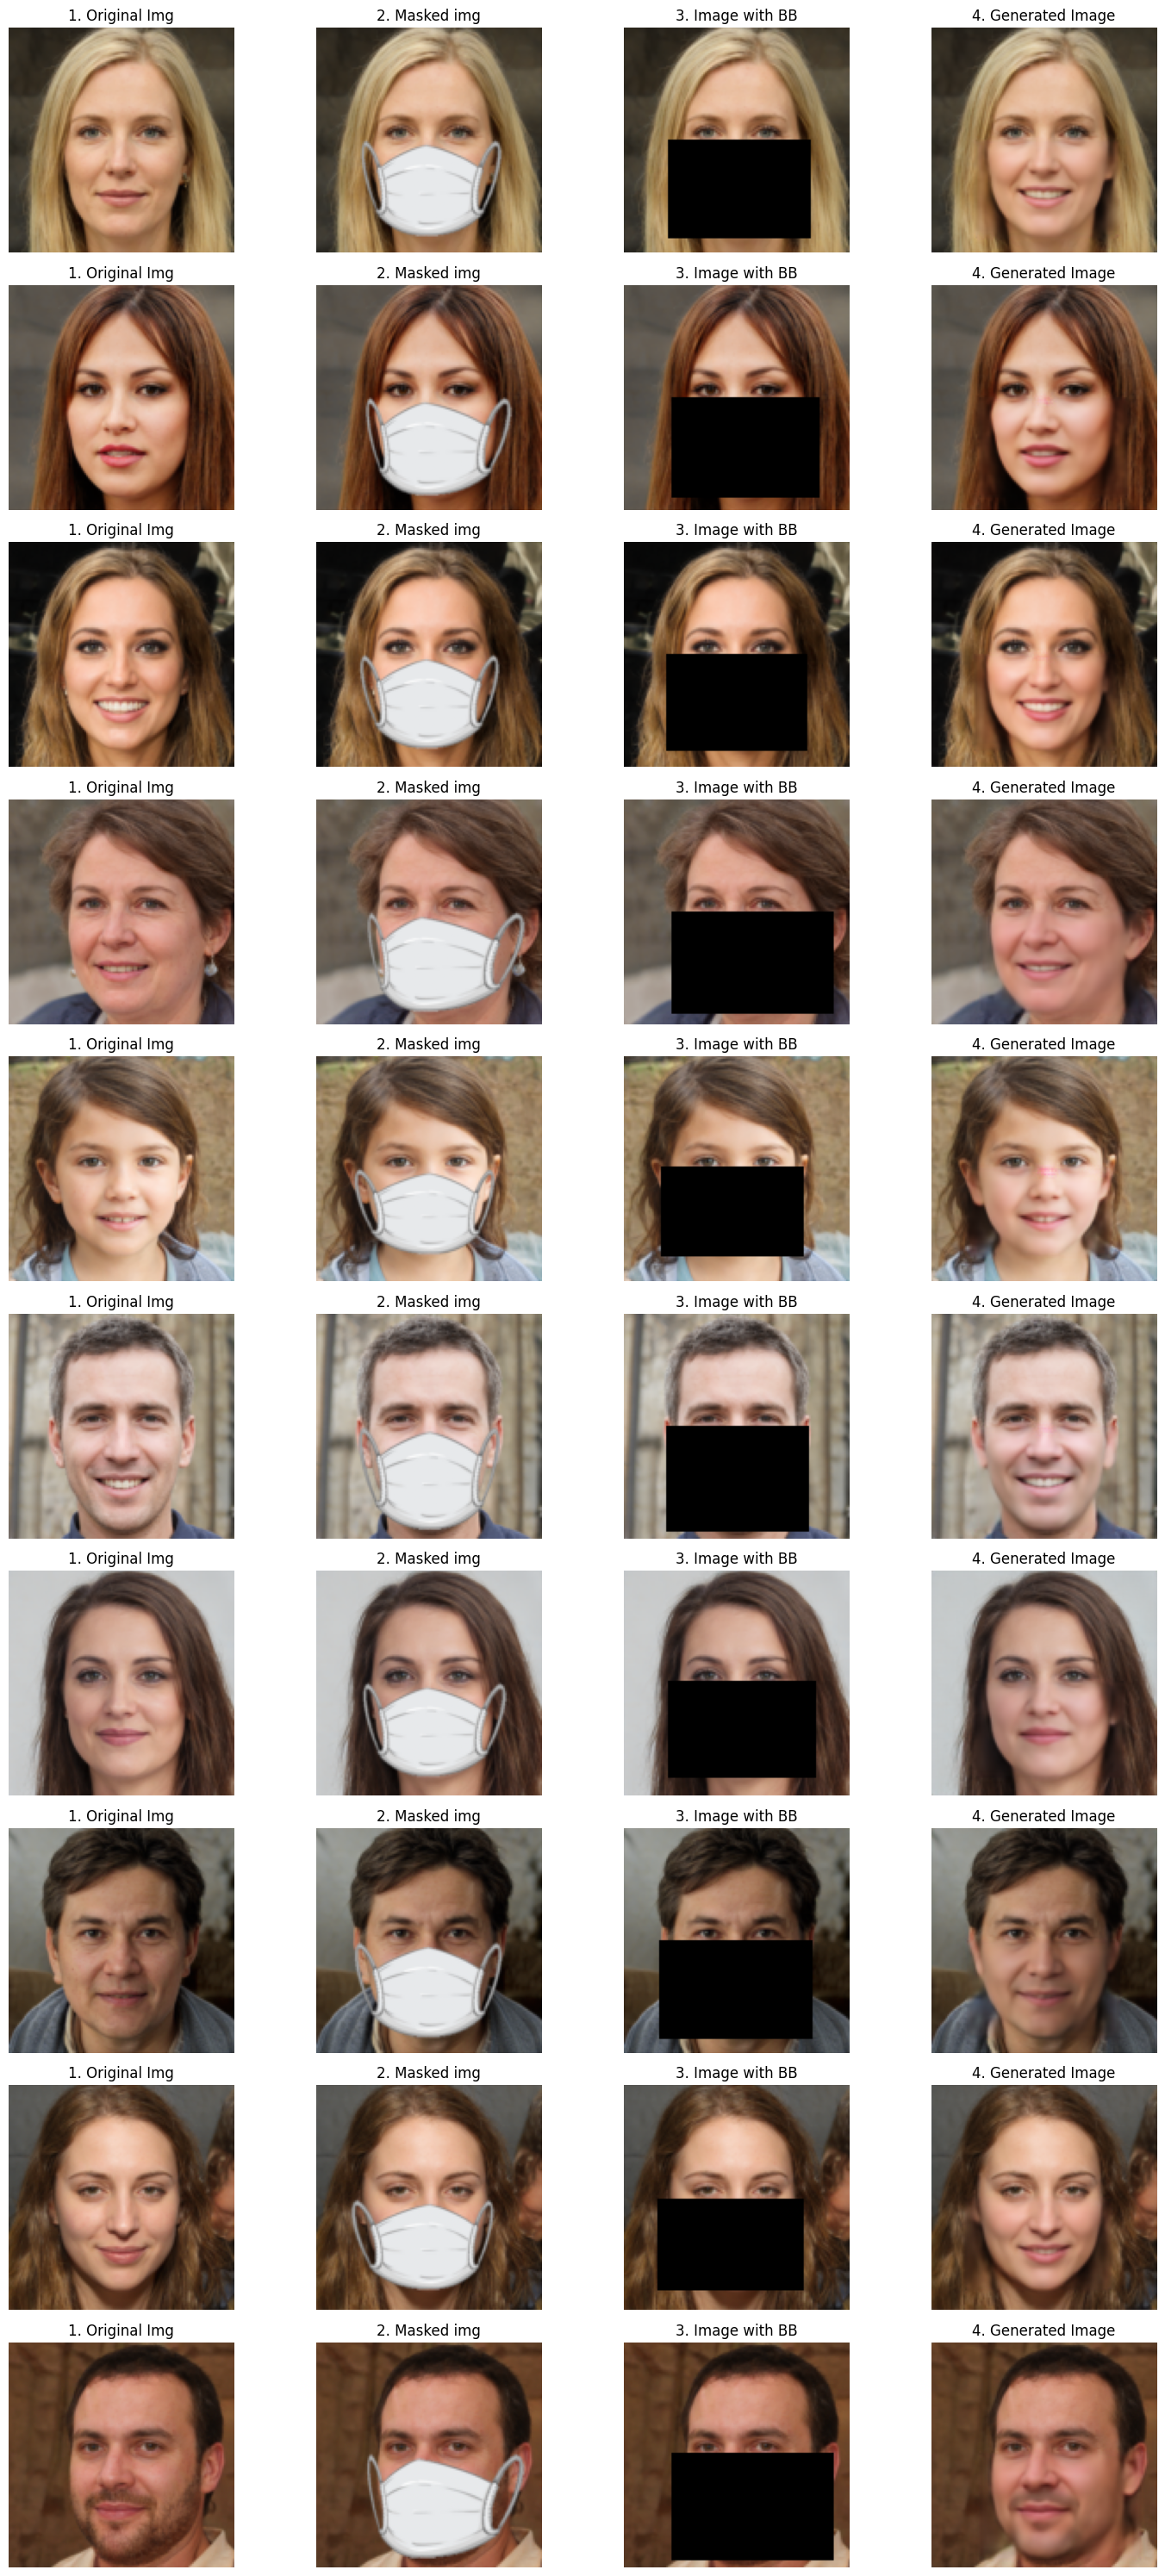

In [8]:
# Hàm hiển thị ba ảnh theo yêu cầu
def display_images(generator, model_yolo, valloader):
    # Lấy một batch từ dataloader
    without_mask_batch, with_mask_batch = next(iter(valloader))
    with_mask_batch = with_mask_batch.to(device)  # Đảm bảo ảnh được chuyển sang GPU nếu có
    batch_size = without_mask_batch.size(0)  # Kích thước batch
    start_index = batch_size - 10  # Chỉ số bắt đầu cho 10 ảnh cuối

    plt.figure(figsize=(15, 30))  # Tăng kích thước hiển thị (rộng x cao)

    for i in range(10):  # Hiển thị 10 ảnh cuối
        idx = start_index + i  # Chỉ số của ảnh trong batch
    
        img_origina = without_mask_batch[idx].cpu()  # Chọn ảnh đầu tiên trong batch và chuyển về CPU
        img_origina = img_origina * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
        img_origina = img_origina.permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) -> (H, W, C)
        
        plt.subplot(10, 4,i*4+1)
        plt.imshow(img_origina)
        plt.title("1. Original Img")
        plt.axis('off')

        # 1. Hiển thị ảnh gốc từ dataloader (ảnh có khẩu trang)
        img_original = with_mask_batch[idx].cpu()  # Chọn ảnh đầu tiên trong batch và chuyển về CPU
        img_original = img_original * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
        img_original = img_original.permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) -> (H, W, C)
        
        plt.subplot(10, 4,i*4+2)
        plt.imshow(img_original)
        plt.title("2. Masked img")
        plt.axis('off')

        # 2. Áp dụng bounding box mask lên ảnh có khẩu trang
        images_with_mask = apply_bounding_box_mask(with_mask_batch, model_yolo)
        img_with_mask = images_with_mask[idx].cpu()  # Chọn ảnh đầu tiên trong batch và chuyển về CPU
        img_with_mask = img_with_mask * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
        img_with_mask = img_with_mask.numpy()  # Chuyển từ (C, H, W) -> (H, W, C)

        plt.subplot(10, 4,i*4+ 3)
        plt.imshow(img_with_mask)
        plt.title("3. Image with BB")
        plt.axis('off')

        # 3. Truyền ảnh qua generator để sinh ảnh mới
        images_with_mask = images_with_mask.to(device)
        generated_images = generator(images_with_mask.permute(0, 3, 1, 2))  # Hoán đổi thứ tự chiều
        generated_image = generated_images[idx].cpu().detach()  # Chọn ảnh đầu tiên và chuyển về CPU
        generated_image = generated_image * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
        generated_image = generated_image.permute(1, 2, 0).numpy()

        plt.subplot(10, 4,i*4+ 4)
        plt.imshow(generated_image)
        plt.title("4. Generated Image")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Load mô hình generator đã huấn luyện
generator = Generator()
generator.load_state_dict(torch.load('C:\\Sam C-Gan project\\checkpoints\\generator_epoch_60.pth'))
generator.to(device)
generator.eval()  # Đặt mô hình ở chế độ đánh giá

model_yolo=YOLO('C:\\Sam C-Gan project\\bounding black box\\mask_detection.pt')

display_images(generator, model_yolo, valloader)